In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from random import choices
from random import sample
from pynverse import inversefunc

In [2]:
"""
Model setup
"""
n = 100
mi = 30
m = 200
prior_e = [0.2, 0.8]

# World 1: signal space 5, clear gap between shirker and worker
signal = [1, 2, 3, 4, 5]
S = len(signal)
w = np.array([0.2, 0.25, 0.25, 0.15, 0.15])
Gamma = np.array([[0.8, 0.1, 0.04, 0.04, 0.02], 
          [0.1, 0.8, 0.08, 0, 0.02],
          [0.01, 0.08, 0.82, 0.06, 0.03],
          [0, 0, 0.08, 0.85, 0.07],
          [0, 0.01, 0.01, 0.08, 0.9]])
Gamma_shirking = np.array([[0.26, 0.34, 0.26, 0.08, 0.06], 
                            [0.24, 0.3, 0.3, 0.11, 0.05],
                            [0.1, 0.28, 0.24, 0.26, 0.12],
                            [0.06, 0.13, 0.28, 0.3, 0.23],
                            [0.12, 0.08, 0.22, 0.3, 0.28]])
Gamma_random = np.ones((S,S))/S

# # World 2: signal space 5, unclear gap between shirker and worker
# signal = [1, 2, 3, 4, 5]
# S = len(signal)
# w = np.array([0.1, 0.1, 0.4, 0.2, 0.2])
# Gamma = np.array([[0.62, 0.22, 0.1, 0.04, 0.02], 
#           [0.14, 0.63, 0.12, 0.09, 0.02],
#           [0.05, 0.16, 0.58, 0.14, 0.07],
#           [0.02, 0.06, 0.15, 0.61, 0.16],
#           [0.02, 0.05, 0.11, 0.18, 0.64]])
# Gamma_shirking = np.array([[0.34, 0.26, 0.26, 0.08, 0.06], 
#                             [0.24, 0.33, 0.27, 0.11, 0.05],
#                             [0.1, 0.24, 0.28, 0.26, 0.12],
#                             [0.06, 0.13, 0.28, 0.3, 0.23],
#                             [0.1, 0.07, 0.21, 0.29, 0.33]])

# World 3: signal space 3,  clear gap between shirker and worker
# signal = [1, 2, 3]
# S = len(signal)
# w = np.array([0.4, 0.3, 0.3])
# Gamma = np.array([[0.85, 0.1, 0.05], 
#           [0.12, 0.8, 0.08],
#           [0.04, 0.08, 0.88]])
# Gamma_shirking = np.array([[0.35, 0.35, 0.3], 
#           [0.32, 0.36, 0.32],
#           [0.28, 0.35, 0.37]])

# World 4: signal space 2, unclear gap between shirker and worker
# signal = [1, 2]
# S = len(signal)
# w = np.array([0.5, 0.5])
# Gamma = np.array([[0.85, 0.15], 
#           [0.12, 0.88]])
# Gamma_shirking = np.array([[0.66, 0.34], 
#           [0.4, 0.6]])


In [3]:
def Report_Generator_Uniform(n, mi, m, prior_e, signal, w, Gamma_e):
    agent = np.arange(len(prior_e))
    agent_e = choices(agent, prior_e, k = n)
    Y = choices(list(range(1, len(w)+1)), w, k = m)
    
    R = []
    for i in agent_e:
        Xi = np.zeros(m)
        Gamma_i = Gamma_e[i]
        task_i = np.array(sample(range(m), mi))
        for j in task_i:
            Xi[j] = choices(signal, Gamma_i[Y[j]-1])[0]
        R.append(Xi)
    
    return (R, Y, np.array(agent_e))

In [4]:
"""
Matrix mechanism
"""

def soft_predictor_learner(X):
    X = np.array(X)
    m = np.size(X, axis = 1)
    P = []
    for j in range(m):
        pj =  np.zeros(S)
        nj = np.count_nonzero(X[:,j])
        if nj != 0:
            for i in range(S):
                pj[i] = np.count_nonzero(X[:,j] == i+1)/nj     
        P.append(pj)
    return np.array(P)

def distribution_estimator(X1, X2): #learn empirical distributions from two agents' reports
    X1 = np.array(X1)
    X2 = np.array(X2)
    P = np.zeros((S,S))
    Q1 = np.zeros(S)
    Q2 = np.zeros(S)
    m = len(X1)
    m1 = np.count_nonzero(X1)
    m2 = np.count_nonzero(X2)
    m12 = np.size(np.intersect1d(np.where(X1 != 0), np.where(X2 != 0)))
    
    for i in range(m):
        if X1[i] != 0 and X2[i] != 0:
            P[int(X1[i])-1][int(X2[i])-1] += 1/m12
        if X1[i] != 0:
            Q1[int(X1[i])-1] += 1/m1
        if X2[i] != 0:
            Q2[int(X2[i])-1] += 1/m2
    
    return P, Q1, Q2

def distribution_learner(report, predictor): #another version of distribution_estimator, which takes a report vector and a soft predictor as inputs
    r = report
    index_i = np.where(r != 0)[0]
    pre = predictor
    P = np.zeros((S,S))
    for j in index_i:
        P[int(r[j])-1]+=pre[j]/len(index_i)
    Q_a = np.zeros(S)
    for j in range(S):
        Q_a[j] = np.count_nonzero(r == j+1)/len(index_i)
    #Q_p = np.sum(pre, axis = 0)/len(pre)
    #Q = Q_p*Q_a.reshape(-1,1)
    return P, Q_a

def MI_computer(P, Q1, Q2, f): #For matrix mechanism, learn different types of mutual information
    Q = Q2*Q1.reshape(-1, 1)
    
    if f == 0:
        MI = np.sum(np.absolute(P - Q))
    elif f == 1:
        t = P*np.log(P/Q)
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 2:
        t = P*(np.square((Q/P)-1))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 3:
        t = P*(np.square(np.sqrt(Q/P)-1))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 4:
        t = P*(np.power((Q/P)-1, 4))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 5:
        t = P*(np.power((Q/P)-1, 6))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    
    return MI

def mechanism_matrix_fast(X, f):
    X = np.array(X)
    n = np.size(X, axis = 0)
    U = np.zeros(n)
    for i in range(n):
        X_ni = np.vstack((X[0:i], X[i+1:n]))
        Pi = soft_predictor_learner(X_ni)
        Q_p = np.sum(Pi, axis = 0)/m
        P, Q_a = distribution_learner(X[i], Pi)
        U[i] = MI_computer(P, Q_a, Q_p, f)
    return U

def mechanism_matrix(X):
    X = np.array(X)
    n = np.size(X, axis = 0)
    U = np.zeros((n,4))
    for i in range(n):
        lis = list(range(n))
        lis.remove(i)
        for j in lis:
            P, Q1, Q2 = distribution_estimator(X[i], X[j])
            U[i] += MI_computer(P, Q1, Q2)/(n-1)
    return U


In [5]:
"""
Determinant mechanism
"""
def distribution_learner_DMI(report, predictor): 
    r = report
    index_i = np.where(r != 0)[0]
    pre = predictor
    P = np.zeros((S,S))
    for j in index_i:
        P[int(r[j])-1]+=pre[j]/len(index_i)
    return P

def mechanism_determinant_fast(X):
    n = np.size(X, axis = 0)
    m = np.size(X, axis = 1)
    mi = np.count_nonzero(X[0])
    U = np.zeros(n)
    for i in range(n):
        X_ni = np.vstack((X[0:i], X[i+1:n]))
        Pi = soft_predictor_learner(X_ni)
        Xi_1 = X[i].copy()
        Xi_1[np.where(X[i] != 0)[0][0:int(mi/2)]] = 0
        Xi_2 = X[i].copy()
        Xi_2[np.where(X[i] != 0)[0][int(mi/2):mi]] = 0
        
        P1 = distribution_learner_DMI(Xi_1, Pi)
        P2 = distribution_learner_DMI(Xi_2, Pi)
        
        U[i] = np.linalg.det(P1)*np.linalg.det(P2)
    return U

def determinant_computer(X1,X2):
    index = np.intersect1d(np.where(X1 != 0), np.where(X2 != 0))
    m12 = len(index)
    P1 = np.zeros((S,S))
    for j in index[0:int(m12/2)]:
        P1[int(X1[j])-1][int(X2[j])-1] += 1/int(m12/2)
    P2 = np.zeros((S,S))
    for j in index[int(m12/2):m12]:
        P1[int(X1[j])-1][int(X2[j])-1] += 1/(m12-int(m12/2))
    return np.linalg.det(P1)*np.linalg.det(P2)

def mechanism_determinant(X):
    n = np.size(X, axis = 0)
    m = np.size(X, axis = 1)
    mi = np.count_nonzero(X[0])
    U = np.zeros(n)
    for i in range(n):
        lis = list(range(n))
        lis.remove(i)
        for j in lis:    
            U[i] += determinant_computer(X[i],X[j])/(n-1)
    return U

In [6]:
def cost(x, a):
    b = 1/(1/(1+np.exp(-a))-1/(1+np.exp(-0.1*a)))
    c = 1 - b/(1+np.exp(-a))
    return np.log((x-c)/(b+c-x))/a

def accuracy_computer_threshold(R, Y, agent_w):
    R = np.array(R)
    R_w = R[np.where(agent_w == 1)[0]]
    m = np.size(Y)
    Y_tilde = np.zeros(m)
    for j in range(m):
        Rj = R_w[:,j]
        if np.count_nonzero(Rj) > 0:
            counts = np.bincount(np.int_(Rj[np.where(Rj != 0)[0]]))
            Y_tilde[j] = np.argmax(counts)
        else:
            Rj = R[:,j]
            counts = np.bincount(np.int_(Rj[np.where(Rj != 0)[0]]))
            Y_tilde[j] = np.argmax(counts)
    # print(Y, Y_tilde)
    acc = np.count_nonzero(Y_tilde == Y)/m
    return acc

In [8]:
n = 30
m = 100
mi = 30
T = 50
alpha = 5
n_s = int(n/4)
Cost = np.arange(0.1, 1.01, 0.01)
cost_a = (lambda x: cost(x, alpha))
Effort = inversefunc(cost_a, y_values=Cost, domain = [0,1])
Acc_matrix = np.zeros((len(Effort), 4))
Acc_fast = np.zeros((len(Effort), 4))
Acc_determinant = np.zeros(len(Effort))
Acc_det_fast = np.zeros(len(Effort))

for l in range(T):
    print('time', l)
    for i, e in enumerate(Effort):
        Gamma_e = e*Gamma + (1-e)*Gamma_shirking
        while True:
            R, Y, agent_e = Report_Generator_Uniform(n, mi, m, prior_e, signal, w, [Gamma_shirking, Gamma_e])
            if np.count_nonzero(np.count_nonzero(np.array(R), axis = 0)) == m:
                break
                
        R_s, _, _ = Report_Generator_Uniform(n_s, mi, m, [1], signal, w, [Gamma_random])
        P_all_matrix = mechanism_matrix(np.vstack((R, R_s)))
        P_all_fast = mechanism_matrix_fast(np.vstack((R, R_s)))
        P_all_determinant = mechanism_determinant_fast(np.vstack((R, R_s)))
        P_all_det_fast = mechanism_determinant(np.vstack((R, R_s)))
        P_matrix = P_all_matrix[0:n]
        P_fast = P_all_fast[0:n]
        P_determinant = P_all_determinant[0:n]
        P_det_fast = P_all_det_fast[0:n]
        t_vs_matrix = np.max(P_all_matrix[n:n+n_s], axis = 0)
        t_vs_fast = np.max(P_all_fast[n:n+n_s], axis = 0)
        t_vs_determinant = np.max(P_all_determinant[n:n+n_s])
        t_vs_det_fast = np.max(P_all_det_fast[n:n+n_s])
        
        agent_w = np.zeros(n)
        agent_w[P_determinant>t_vs_determinant] = 1
        Acc_determinant[i] += accuracy_computer_threshold(R, Y, agent_w)/T
        agent_w = np.zeros(n)
        agent_w[P_det_fast>t_vs_det_fast] = 1
        Acc_det_fast[i] += accuracy_computer_threshold(R, Y, agent_w)/T
        for k in range(4):
            agent_w = np.zeros(n)
            agent_w[P_matrix[:,k]>t_vs_matrix[k]] = 1
            Acc_matrix[i,k] += accuracy_computer_threshold(R, Y, agent_w)/T
            agent_w = np.zeros(n)
            agent_w[P_fast[:,k]>t_vs_fast[k]] = 1
            Acc_fast[i,k] += accuracy_computer_threshold(R, Y, agent_w)/T
            

time 0


TypeError: MI_computer() missing 1 required positional argument: 'f'

Text(0, 0.5, 'Accuracy')

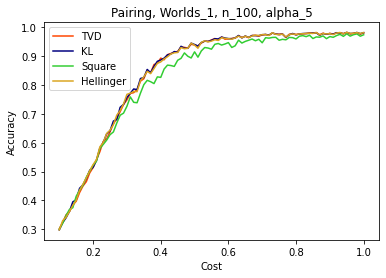

In [73]:
plt.figure()
MI = ['TVD', 'KL', 'Square', 'Hellinger', '4th']
colors = ['orangered', 'navy', 'limegreen', 'goldenrod', 'mediumpurple']
for k in range(4):
    plt.plot(Cost, Acc_fast[:,k], color = colors[k], label = MI[k])
plt.legend()
plt.title('Pairing, Worlds_1, n_100, alpha_5')
plt.xlabel('Cost')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

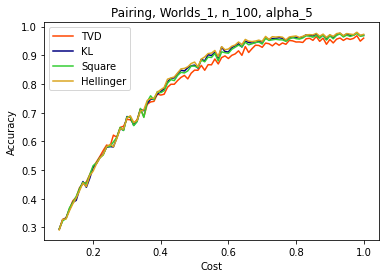

In [75]:
plt.figure()
MI = ['TVD', 'KL', 'Square', 'Hellinger', '4th']
colors = ['orangered', 'navy', 'limegreen', 'goldenrod', 'mediumpurple']
for k in range(4):
    plt.plot(Cost, Acc_matrix[:,k], color = colors[k], label = MI[k])
plt.legend()
plt.title('Pairing, Worlds_1, n_100, alpha_5')
plt.xlabel('Cost')
plt.ylabel('Accuracy')

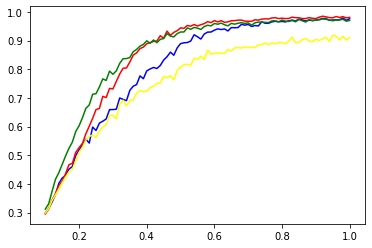

In [83]:
k = 3
plt.figure()
plt.plot(Cost, Acc_matrix[:,k], color = 'blue')
plt.plot(Cost, Acc_fast[:,k], color = 'red')
plt.plot(Cost, Acc_determinant, color = 'yellow')
plt.plot(Cost, Acc_det_fast, color = 'green')

In [8]:
"""
Pairing mechanism
"""

def Soft_pred_to_MI(Marginal, pred, b, p, q, Y_T, f):
    # Mi = np.zeros(5)
    # K_b = np.zeros(5)
    # K_p = np.zeros(5)
    Mi = 0
    K_b = 0
    K_p = 0
    predict_b = pred[b]
    predict_p = pred[p]

    if Marginal[Y_T[b]-1] != 0:
        Jp_b = predict_b[Y_T[b]-1]/Marginal[Y_T[b]-1]
        if f == 0:
            if Jp_b > 1:
                K_b = 0.5
            elif Jp_b < 1:
                K_b = -0.5
        elif f == 1:
            if 1 + np.log(Jp_b) < -10:
                K_b = -10
            elif 1 + np.log(Jp_b) > 10:
                K_b = 10
            else:
                K_b = 1 + np.log(Jp_b)
        elif f == 2:
            K_b = 2*(Jp_b - 1)
        elif f == 3:
            if 1 - 1/np.sqrt(Jp_b) < -10:
                K_b = -10
            else:
                K_b = 1 - 1/np.sqrt(Jp_b)
        elif f == 4:
            K_b = 4*np.power(Jp_b - 1, 3)
        elif f == 5:
            K_b = 6*np.power(Jp_b - 1, 5)
        
    if Marginal[Y_T[q]-1] != 0:
        Jp_p = predict_p[Y_T[q]-1]/Marginal[Y_T[q]-1]
        if f == 0:
            if Jp_p > 1:
                K_p = 0.5
            elif Jp_p < 1:
                K_p = -0.5
            Mi = K_b - K_p
            
        elif f == 1:
            kl = 1 + np.log(Jp_p)
            if kl < -10:
                K_p = -10
            elif kl > 10:
                K_p = 10
            else:
                K_p = kl
            Mi = K_b - np.exp(K_p-1)
            
        elif f == 2:
            K_p = 2*(Jp_p - 1)
            Mi = K_b - np.square(K_p)/4 - K_p
            
        elif f == 3:
            heli = 1 - 1/np.sqrt(Jp_p)
            if heli < -10:
                K_p = -10
            else:
                K_p = heli
            Mi = K_b - K_p/(1-K_p)
            
        elif f == 4:
            K_p = 4*np.power(Jp_p - 1, 3)
            Mi = K_b - np.power(np.abs(K_p)/4, 1/3)*np.abs(K_p)*3/4 - K_p
        elif f == 5:
            K_p = 6*np.power(Jp_p - 1, 5)
            Mi = K_b - np.power(np.abs(K_p)/6, 1/5)*np.abs(K_p)*5/6 - K_p
    
    return Mi


def soft_predictor_learner(X):
    X = np.array(X)
    m = np.size(X, axis = 1)
    P = []
    for j in range(m):
        pj =  np.zeros(S)
        nj = np.count_nonzero(X[:,j])
        if nj != 0:
            for i in range(S):
                pj[i] = np.count_nonzero(X[:,j] == i+1)/nj     
        P.append(pj)
    return np.array(P)

def LR_learner_2(X, Y, f):
    Y = np.array(Y)
    T = np.size(np.where(Y != 0)[0])*10
    index_i = np.where(Y != 0)[0]
    Yi = Y[index_i]
    M = 0
    
    Y_int = Y.copy().astype(int)
    pred = soft_predictor_learner(X)
    Marginal = np.zeros(S)
    for j in signal:
        Marginal[j-1] = np.count_nonzero(Yi == j)/len(Yi)
    for j in range(T):
        b,q = sample(list(index_i), 2)
        p = sample(range(len(Y)), 1)[0]
        while p == b or p == q:
            p = sample(range(len(Y)),1)[0]
        Mi = Soft_pred_to_MI(Marginal, pred, b, p, q, Y_int, f)
        M += Mi
    M = M/(T)

    return M


# Pairing mechanism, can be used as black box. Now it requires ground truth, which is a perfect predictor of agents' reports.
# In reality, Gr can be replaced by a soft learning algorithm.
def mechanism_pairing_learning_3(X, f):
    n = len(X)

    X = np.array(X)
    U = np.zeros(n)
    for i in range(n):
        X_ni = np.vstack((X[0:i], X[i+1:n]))
        U[i] = LR_learner_2(X_ni, X[i], f)

    return U

def LR_learner_3(pred, Y):
    Y = np.array(Y)
    T = np.size(np.where(Y != 0)[0])*10
    index_i = np.where(Y != 0)[0]
    Yi = Y[index_i]
    M = np.zeros(4)
    
    Y_int = Y.copy().astype(int)
    Marginal = np.zeros(S)
    for j in signal:
        Marginal[j-1] = np.count_nonzero(Yi == j)/len(Yi)
    for j in range(T):
        b,q = sample(list(index_i), 2)
        p = sample(range(len(Y)), 1)[0]
        while p == b or p == q:
            p = sample(range(len(Y)),1)[0]
        Mi = Soft_pred_to_MI(Marginal, pred, b, p, q, Y_int)
        M += Mi
    M = M/(T)

    return M

def mechanism_pairing_4(Xa, Xb, Xs):
    ns = np.size(Xs, axis=0)
    na = np.size(Xa, axis=0)
    Us = np.zeros((ns, 4))
    for i in range(ns):
        X_ni = np.vstack((Xs[0:i], Xs[i+1:ns], Xb))
        Us[i] = LR_learner_2(X_ni, Xs[i])
    pred = soft_predictor_learner(np.vstack((Xs, Xb)))
    Ua = np.zeros((na, 4))
    for i in range(na):
        Ua[i] = LR_learner_3(pred, Xa[i])
    return Ua, Us

In [ ]:
n = 30
m = 100
mi = 80
Effort = np.arange(0, 1.01, 0.01)
Thresholds = np.arange(1,n,1)
Amplitudes = np.arange(0.5, 3.01, 0.02)
T = 80
alpha = 5
U_vs = np.zeros((len(Effort), len(Amplitudes), 4))
U_vs2 = np.zeros((len(Effort), len(Amplitudes), 4))
U_t = np.zeros((len(Effort), len(Thresholds), len(Amplitudes), 4))
Payments_vs = np.zeros((len(Effort), len(Amplitudes), 4))
Payments_vs2 = np.zeros((len(Effort), len(Amplitudes), 4))
Payments_t = np.zeros((len(Effort), len(Thresholds), len(Amplitudes), 4))
Acc_vs = np.zeros((len(Effort), 4))
Acc_vs2 = np.zeros((len(Effort), 4))
Acc_t = np.zeros((len(Effort), len(Thresholds), 4))

for l in range(T):
    print('round ',l)
    for i, e in enumerate(Effort):
        Gamma_e = e*Gamma + (1-e)*Gamma_shirking
        while True:
            R, Y, agent_e = Report_Generator_Uniform(n, mi, m, prior_e, signal, w, [Gamma_shirking, Gamma_e, Gamma])
            if np.count_nonzero(np.count_nonzero(np.array(R), axis = 0)) == m:
                break
        R = np.array(R)
        agent_w = np.ones((n,4))
        agent_w_once = np.ones((n,4))
        P_once = np.zeros((n,4))
        count = 0
        while True:
            agent_w_new = agent_w.copy()
            for k in range(4):
                n_w = np.count_nonzero(agent_w[:,k])
                n_s = int(n_w/5) + 1
                R_s, _, _ = Report_Generator_Uniform(n_s, mi, m, [1], signal, w, [Gamma_random])
                R_w = R[np.where(agent_w[:,k] == 1)[0]]
                P_all = mechanism_pairing_learning_3(np.vstack((R_w, R_s)), k)
                P = P_all[0:n_w]
                if n_w == n:
                    P_once[:,k] = P
                t_vs = np.max(P_all[n_w:n_w+n_s])
                agent_w_new[np.where(agent_w[:,k] == 1)[0][np.where(P <= t_vs)[0]], k] = 0
            if n_w == n:
                agent_w_once = agent_w_new.copy()
            # print(np.count_nonzero(agent_w, axis = 0))
            if np.array_equal(agent_w_new, agent_w) or count == 100:
                break
            else:
                count += 1
                agent_w = agent_w_new.copy()
        
        
        c = cost(e, alpha)
        for k in range(4):
            Acc_vs[i,k] += accuracy_computer_threshold(R, Y, agent_w_once[:,k])/T
            Acc_vs2[i,k] += accuracy_computer_threshold(R, Y, agent_w[:,k])/T
        for h, a in enumerate(Amplitudes):
            P_step_vs = np.zeros((n,4)) + 0.1
            P_step_vs[agent_w_once == 1] = a
            U_vs[i, h] += (np.average(P_step_vs[agent_e == 1], axis = 0) - c)/T
            Payments_vs[i,h] += np.average(P_step_vs, axis = 0)/T
            P_step_vs = np.zeros((n,4)) + 0.1
            P_step_vs[agent_w == 1] = a
            U_vs2[i, h] += (np.average(P_step_vs[agent_e == 1], axis = 0) - c)/T
            Payments_vs2[i,h] += np.average(P_step_vs, axis = 0)/T
        
        argsort_agent = P_once.argsort(axis = 0)
        for j, t in enumerate(Thresholds):
            for k in range(4):
                agent_w_t = np.zeros(n)
                agent_w_t[argsort_agent[-t:,k]] = 1
                Acc_t[i,j,k] += accuracy_computer_threshold(R, Y, agent_w_t)/T
            for h, a in enumerate(Amplitudes):
                P_step_t = np.zeros((n,4)) + 0.1
                P_step_t[argsort_agent[-t:,k]] = a
                U_t[i, j, h] += (np.average(P_step_t[agent_e == 1], axis = 0) - c)/T
                Payments_t[i,j,h] += np.average(P_step_t, axis = 0)/T
    

round  0


<ipython-input-8-f76e479cd549>:51: RuntimeWarning: divide by zero encountered in log
  kl = 1 + np.log(Jp_p)
<ipython-input-8-f76e479cd549>:23: RuntimeWarning: divide by zero encountered in log
  if 1 + np.log(Jp_b) < -10:
<ipython-input-8-f76e479cd549>:65: RuntimeWarning: divide by zero encountered in double_scalars
  heli = 1 - 1/np.sqrt(Jp_p)
<ipython-input-8-f76e479cd549>:32: RuntimeWarning: divide by zero encountered in double_scalars
  if 1 - 1/np.sqrt(Jp_b) < -10:


round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9
round  10
round  11
round  12
round  13
round  14
round  15
round  16
round  17
round  18
round  19
round  20
round  21
round  22
round  23
round  24
round  25
round  26
round  27
round  28
round  29
round  30
round  31
round  32
round  33
round  34
round  35
round  36
round  37
round  38
round  39
round  40
round  41
round  42
round  43
round  44
round  45
round  46
round  47
round  48
round  49


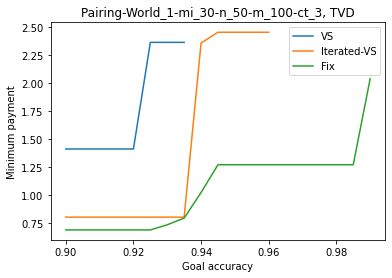

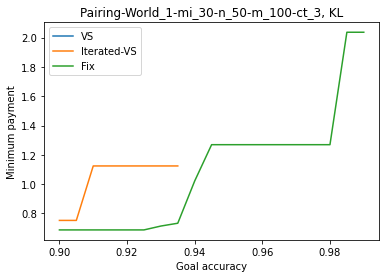

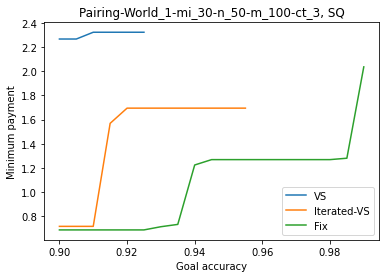

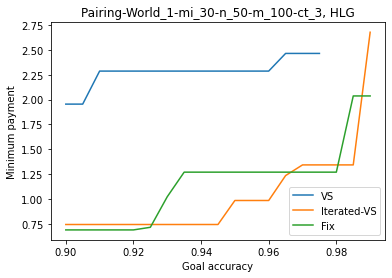

In [20]:
"""
Data analysis
"""

def min_payment(Acc_goal):
    Payment_min_vs = np.zeros(4)
    Effort_min_vs = np.zeros(4)
    Payment_min_vs2 = np.zeros(4)
    Effort_min_vs2 = np.zeros(4)

    Effort_emp = np.argmax(U_vs, axis = 0)
    for k in range(4):
        if np.count_nonzero(Acc_vs[:,k] >= Acc_goal) == 0:
            amplitude_range_vs = []
        else:
            index_acc = next(x for x in Acc_vs[:,k] if x >= Acc_goal)
            min_effort_vs = np.where(Acc_vs[:,k] == index_acc)[0][0]
            amplitude_range_vs = np.where(Effort_emp[:,k] >= min_effort_vs)[0]
        pay_min_k = np.inf
        eff_min_k = -1
        for h in amplitude_range_vs:
            if Payments_vs[Effort_emp[h,k],h,k] < pay_min_k:
                pay_min_k = Payments_vs[Effort_emp[h,k],h,k]
                eff_min_k = Effort[Effort_emp[h,k]]
        Payment_min_vs[k] = pay_min_k
        Effort_min_vs[k] = eff_min_k
    
    Effort_emp = np.argmax(U_vs2, axis = 0)
    for k in range(4):
        if np.count_nonzero(Acc_vs2[:,k] >= Acc_goal) == 0:
            amplitude_range_vs = []
        else:
            index_acc = next(x for x in Acc_vs2[:,k] if x >= Acc_goal)
            min_effort_vs = np.where(Acc_vs2[:,k] == index_acc)[0][0]
            amplitude_range_vs = np.where(Effort_emp[:,k] >= min_effort_vs)[0]
        pay_min_k = np.inf
        eff_min_k = -1
        for h in amplitude_range_vs:
            if Payments_vs2[Effort_emp[h,k],h,k] < pay_min_k:
                pay_min_k = Payments_vs2[Effort_emp[h,k],h,k]
                eff_min_k = Effort[Effort_emp[h,k]]
        Payment_min_vs2[k] = pay_min_k
        Effort_min_vs2[k] = eff_min_k

    Payment_min_opt = np.zeros(4)
    Effort_min_opt = np.zeros(4)
    
    Effort_opt = np.argmax(U_t, axis = 0)
    for k in range(4):
        pay_min_k = np.inf
        eff_min_k = -1
        for j,t in enumerate(Thresholds):
            if np.count_nonzero(Acc_t[:,j,k] >= Acc_goal) == 0:
                amplitude_range_t = []
            else:
                index_acc = next(x for x in Acc_t[:,j,k] if x >= Acc_goal)
                min_effort_t = np.where(Acc_t[:,j,k] == index_acc)[0][0]
                amplitude_range_t = np.where(Effort_opt[j,:,k] >= min_effort_t)[0]
          
            for h in amplitude_range_t:
                if Payments_t[Effort_opt[j,h,k],j,h,k] < pay_min_k:
                    pay_min_k = Payments_t[Effort_opt[j,h,k],j,h,k]
                    eff_min_k = Effort[Effort_opt[j,h,k]]
        Payment_min_opt[k] = pay_min_k
        Effort_min_opt[k] = eff_min_k
    return Payment_min_vs, Payment_min_vs2, Payment_min_opt

# Payment_min_vs, Payment_min_vs2, Payment_min_opt = min_payment(0.95)
# print('Matrix-World_1-mi_30-n_50-m_100-acc_95','\n')
# print('Virtual shirker min_payment: ', '\n', Payment_min_vs)
# print('Iterated virtual shirker min_payment: ', '\n', Payment_min_vs2)
# print('Optimal min_payment: ', '\n', Payment_min_opt)
# print('Virtual shirker elicited efforts: ','\n', Effort_min_vs)
# print('Iterated virtual shirker elicited efforts: ','\n', Effort_min_vs2)
# print('Optimal elicited efforts: ', '\n', Effort_min_opt)

Acc_goal = np.arange(0.9, 0.995, 0.005)
Paymin = np.zeros((4, len(Acc_goal), 3))
for i, acc in enumerate(Acc_goal):
    Payment_min_vs, Payment_min_vs2, Payment_min_opt = min_payment(acc)
    for k in range(4):
        Paymin[k, i, 0] = Payment_min_vs[k]
        Paymin[k, i, 1] = Payment_min_vs2[k]
        Paymin[k, i, 2] = Payment_min_opt[k]
    
MI = ['TVD', 'KL', 'SQ', 'HLG']
for k in range(4):
    plt.figure()
    plt.plot(Acc_goal, Paymin[k,:,0], label = 'VS')
    plt.plot(Acc_goal, Paymin[k,:,1], label = 'Iterated-VS')
    plt.plot(Acc_goal, Paymin[k,:,2], label = 'Fix')
    plt.xlabel('Goal accuracy')
    plt.ylabel('Minimum payment')
    plt.title('Pairing-World_1-mi_30-n_50-m_100-ct_3, '+MI[k])
    plt.legend()


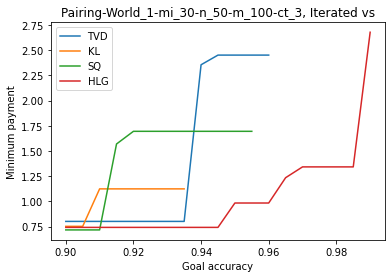

In [19]:
Acc_goal = np.arange(0.9, 0.995, 0.005)
Paymin = np.zeros((4, len(Acc_goal), 3))
for i, acc in enumerate(Acc_goal):
    Payment_min_vs, Payment_min_vs2, Payment_min_opt = min_payment(acc)
    for k in range(4):
        Paymin[k, i, 0] = Payment_min_vs[k]
        Paymin[k, i, 1] = Payment_min_vs2[k]
        Paymin[k, i, 2] = Payment_min_opt[k]
    
MI = ['TVD', 'KL', 'SQ', 'HLG']
plt.figure()
for k in range(4):
    plt.plot(Acc_goal, Paymin[k,:,1], label = MI[k])
    plt.xlabel('Goal accuracy')
    plt.ylabel('Minimum payment')
    plt.title('Pairing-World_1-mi_30-n_50-m_100-ct_3, Iterated vs')
    plt.legend()

<ipython-input-4-5b31836e3381>:69: RuntimeWarning: divide by zero encountered in true_divide
  t = P*(np.square(np.sqrt(Q/P)-1))
<ipython-input-4-5b31836e3381>:69: RuntimeWarning: invalid value encountered in multiply
  t = P*(np.square(np.sqrt(Q/P)-1))
<ipython-input-4-5b31836e3381>:69: RuntimeWarning: invalid value encountered in true_divide
  t = P*(np.square(np.sqrt(Q/P)-1))
<ipython-input-8-f76e479cd549>:65: RuntimeWarning: divide by zero encountered in double_scalars
  heli = 1 - 1/np.sqrt(Jp_p)
<ipython-input-8-f76e479cd549>:32: RuntimeWarning: divide by zero encountered in double_scalars
  if 1 - 1/np.sqrt(Jp_b) < -10:


Text(0.5, 1.0, 'Pairing')

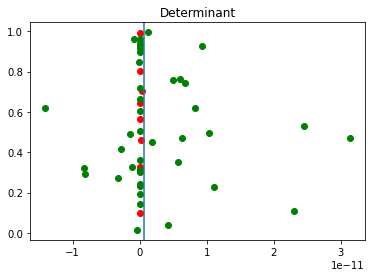

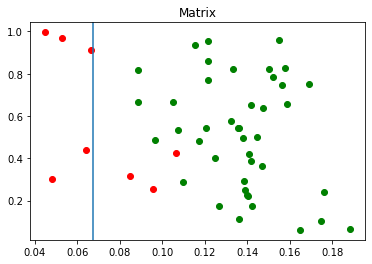

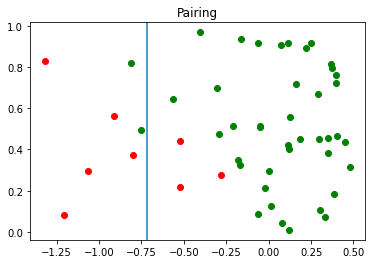

In [13]:
n = 50
n_s = 10
e = 0.8
Gamma_e = e*Gamma + (1-e)*Gamma_shirking
R, Y, agent_e = Report_Generator_Uniform(n, mi, m, prior_e, signal, w, [Gamma_shirking, Gamma_e])
R_s, _, _ = Report_Generator_Uniform(n_s, mi, m, [1], signal, w, [Gamma_random])
P_all = mechanism_determinant_fast(np.vstack((R, R_s)))
P = P_all[0:n_w]
t_vs = np.max(P_all[n:n+n_s])

plt.figure()
plt.scatter(P_all[0:n][agent_e == 0], np.random.uniform(0,1,len(P_all[0:n][agent_e == 0])), color = 'red')
plt.scatter(P_all[0:n][agent_e == 1], np.random.uniform(0,1,len(P_all[0:n][agent_e == 1])), color = 'green')
plt.axvline(x = t_vs)
plt.title('Determinant')

P_all = mechanism_matrix_fast(np.vstack((R, R_s)), 3)
P = P_all[0:n_w]
t_vs = np.max(P_all[n:n+n_s])

plt.figure()
plt.scatter(P_all[0:n][agent_e == 0], np.random.uniform(0,1,len(P_all[0:n][agent_e == 0])), color = 'red')
plt.scatter(P_all[0:n][agent_e == 1], np.random.uniform(0,1,len(P_all[0:n][agent_e == 1])), color = 'green')
plt.axvline(x = t_vs)
plt.title('Matrix')

P_all = mechanism_pairing_learning_3(np.vstack((R, R_s)), 3)
P = P_all[0:n_w]
t_vs = np.max(P_all[n:n+n_s])

plt.figure()
plt.scatter(P_all[0:n][agent_e == 0], np.random.uniform(0,1,len(P_all[0:n][agent_e == 0])), color = 'red')
plt.scatter(P_all[0:n][agent_e == 1], np.random.uniform(0,1,len(P_all[0:n][agent_e == 1])), color = 'green')
plt.axvline(x = t_vs)
plt.title('Pairing')